In [3]:
# !apt-get update
# !apt-get install -y build-essential python-dev
# !pip install -U scikit-learn
# !pip install bertopic
# #!pip install TextBlob
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [4]:
#!pip install bertopic

In [5]:
# !pip install bertopic[flair]
# !pip install bertopic[gensim]
# !pip install bertopic[spacy]
# !pip install bertopic[use]
#!pip install joblib

In [6]:
from bertopic import BERTopic

In [7]:
import spacy


import time
nlp = spacy.load('en_core_web_sm')

import numpy as np
import pandas as pd
import csv
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#from textblob import TextBlob
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import randint
from sklearn.base import BaseEstimator, ClusterMixin

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

from bertopic.vectorizers import ClassTfidfTransformer


In [8]:
datafile = './sedar_pr_2018.csv'
raw_data = []
csv.field_size_limit(100000000) 

with open(datafile, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        raw_data.append(row['TEXT'])

raw_data1 = [text for text in raw_data if text]#[:1000]

In [9]:
raw_data = [text for text in raw_data if text]
final_data_ = []

for text in raw_data:
    # Remove information after "For further information"
    text = re.sub(r'For further information.*', '', text)
    
    final_data_.append(text.strip())

len(final_data_)

29016

In [10]:
start_time = time.time()

def extract_entities(docs):
    cleaned_texts = []
    for doc in docs:
        entities = [ent.text for ent in doc.ents if ent.label_ in ['ORG', 
                                                                   'LOC', 
                                                                   'PERSON',
                                                                   'DATE', 
                                                                    'TIME', 
                                                                   'PERCENT',
                                                                   'MONEY',
                                                                   'QUANTITY', 
                                                                    'ORDINAL', 
                                                                   'CARDINAL', 
                                                                   'EMAIL',
                                                                   'PHONE', 
                                                                   "SYM", 
                                                                   'GPE']]
        text = doc.text
        for entity in entities:
            text = text.replace(entity, '')
        cleaned_texts.append(text.strip())
    return cleaned_texts

batch_size = 500
cleaned_raw_data = []

for i in range(0, len(final_data_), batch_size):
    print(i)
    docs = nlp.pipe(final_data_[i:i+batch_size], disable=["parser", "tagger"])
    cleaned_raw_data.extend(extract_entities(docs))

end_time = time.time()   
print(f"Time taken by the function: {end_time - start_time} seconds")

len(cleaned_raw_data)


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
Time taken by the function: 2294.260092496872 seconds


29016

In [11]:
stop_words = set(stopwords.words('english'))
pos_stop_words = [
    'am', 'is', 'are', 'was', 'were', 'be', 'being', 'been',
    'can', 'could', 'shall', 'should', 'will', 'would', 'may', 'might', 'must',
    'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them',
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
    'first', 'second', 'third', 'last',
    'john', 'mary', 'london', 'paris', 'company',
    'on', 'in', 'at', 'to', 'with', 'by', 'from', 'into', 'through', 'over',
    'between', 'before', 'after', 'under', 'above', 'below', 'up', 'down',
    'out', 'off', 'about', 'around', 'throughout', 'inside', 'outside',
    "statements", "forward", "looking", "information",
    "available", "website", "please", "visit", "www", "com", "follow", "twitter", "facebook"
]

In [12]:
stop_words.update(pos_stop_words)

In [13]:
final_data = []

for text in cleaned_raw_data:
    # Remove single characters
    text = re.sub(r'\b\w\b', '', text)
    
    # Remove numbers
    text = re.sub(r'\b\d+\b', '', text)
    
    final_data.append(text.strip())
    
len(final_data)

29016

In [14]:
# Remove newlines, carriage returns, and tabs
raw_data = [re.sub(r'[\n\r\t]', ' ', text) for text in final_data]

In [15]:

# Remove multiple spaces and replace them with a single space
raw_data = [re.sub('\s+', ' ', text).strip() for text in raw_data]
len(raw_data)

29016

In [16]:

# Filter to only keep texts with more than 1 word
raw_data = [text for text in raw_data if len(text.split()) > 1]

In [17]:
def remove_long_words(text, max_length=15, min_length=2):
    words = text.split()
    short_words = [word for word in words if len(word) <= max_length and len(word) >= min_length]
    return ' '.join(short_words)

raw_data = [remove_long_words(text) for text in raw_data]
len(raw_data)

28995

In [18]:

# Filter out texts that only contain numbers or special characters
raw_data = [text for text in raw_data if not text.isnumeric() and not all(not char.isalnum() for char in text)]
len(raw_data)

28975

In [19]:

# Remove consecutive duplicates of special characters
raw_data = [re.sub(r'(\W)\1+', r'\1', text) for text in raw_data]

In [20]:
# Lowercasing
lowercased_data = [text.lower() for text in raw_data]

# Removing URL, HTML tags, or other specific patterns
cleaned_data = []
for text in lowercased_data:
    cleaned_text = re.sub(r'http\S+', '', text)
    cleaned_data.append(cleaned_text.strip())
    
len(cleaned_data)

28975

In [21]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
lemmatized_data = [lemmatizer.lemmatize(text) for text in cleaned_data]

# Stopword Removal

filtered_data = []
for text in lemmatized_data:
    words = re.findall(r'\b\w+\b', text)
    filtered_text = [word for word in words if word not in stop_words]
    filtered_data.append(' '.join(filtered_text))
len(filtered_data)

28975

In [22]:
# Spelling Correction
# corrected_data = []
# for text in filtered_data:
#     corrected_text = str(TextBlob(text).correct())
#     corrected_data.append(corrected_text)    corrected_data.extend(corrected_batch)



In [23]:
filtered_data[5:6]

['packaging due diligence proposed acquisition vancouver medical inc prev otcqb prvcf fse announces update due diligence penta group companies connection proposed acquisition penta group acquisition assets include brands market ready products previously announced advance due diligence process management team scheduled due diligence trip due diligence trip leased packaging facility located used packaging food beverages non food items hemp products due diligence trip include tour approved filling packing rooms sealing machinery bonded warehouse well full range low high speed production lines mr chairman ceo president stated happy results due diligence date ready conduct site inspection operations excited understand full scope penta facility diverse capabilities determine applied future growth health sciences develops innovative options preventive curative therapies utilizing organic nature identical products aims leader preventive health sciences currently research development programs i

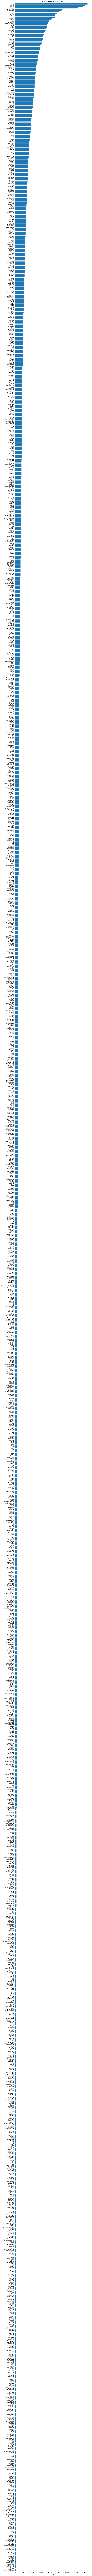

In [24]:
# Flatten the cleaned_raw_data list into a single string
text = ' '.join(filtered_data)

# Replace 'x' with 'y' and 'y' with 'x'
text = text.replace('x', 'temp').replace('y', 'x').replace('temp', 'y')

# Tokenize the text into individual words
words = text.split()

# Count the occurrences of each word
word_counts = Counter(words)

# Filter the word counts to include only those greater than 60
filtered_word_counts = {word: count for word, count in word_counts.items() if count > 1000}

# Sort the filtered word counts in descending order
sorted_word_counts = sorted(filtered_word_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the words and their counts
sorted_words = [pair[0] for pair in sorted_word_counts]
counts = [pair[1] for pair in sorted_word_counts]


plt.figure(figsize=(10, 300))
plt.barh(range(len(sorted_words)), counts[::-1])  # Use barh for horizontal bar plot
plt.yticks(range(len(sorted_words)), sorted_words[::-1])  # Set y-axis ticks and labels
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Word Counts (Count > 60)')

# Adjust padding
plt.subplots_adjust(top=0.98)  # Decrease the top padding
plt.ylim(-0.2, len(sorted_words) - 0.2)  # Set the y-axis limits

plt.show()



In [25]:
raw_data_list = filtered_data#[:2000]#raw_data["TEXT"].tolist()#[:200]
raw_data_list_sample = filtered_data[1000:25000]

In [26]:
with open('list.txt', 'w') as file:
    for item in filtered_data:
        file.write(str(item) + '\n')

In [27]:
#raw_data_list[:2]

In [28]:

# Prepare embeddings

sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(raw_data_list_sample, show_progress_bar=True)


In [29]:
#embeddings

In [30]:
# Assuming 'embeddings' is your numpy array
#documents = embeddings.tolist()

# Convert any sub-arrays into strings
#documents = [' '.join(map(str, doc)) if isinstance(doc, list) else str(doc) for doc in documents]

In [31]:

# Define the parameter distributions for UMAP
param_distributions = {
    'n_neighbors': [10, 20, 30, 50, 100, 200, 300, 400, 500, 700],
    'min_dist': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    'metric': ['cosine', 'euclidean', 'manhattan']
}

# Create a UMAP model
umap_model = UMAP()

# Create the RandomizedSearchCV model
random_search = RandomizedSearchCV(estimator=umap_model,
                                   param_distributions=param_distributions,
                                   n_iter=10, 
                                   scoring='neg_mean_squared_error', 
                                   cv=5,
                                   n_jobs=-1)

# Fit the RandomizedSearchCV model (Assuming X is your input data)
random_search.fit(embeddings)

# Get the best parameters
best_params_umap = random_search.best_params_


In [32]:
best_params_umap

{'n_neighbors': 200, 'min_dist': 0.5, 'metric': 'euclidean'}

In [33]:

# Define the parameter distributions for CountVectorizer
param_distributions = {
    'ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3)],
    'stop_words': ['english'],
    'min_df': [5, 10, 15, 20, 50],
    #'max_features': randint(1000, 10000)
}

# Create a CountVectorizer model
vectorizer_model = CountVectorizer()

# Create the RandomizedSearchCV model
random_search = RandomizedSearchCV(estimator=vectorizer_model, 
                                   param_distributions=param_distributions,
                                   n_iter=10, 
                                   scoring='neg_mean_squared_error', 
                                   cv=5,
                                   n_jobs=-1)


# Now you can fit your model
random_search.fit(raw_data_list_sample)


# Get the best parameters
best_params_cv = random_search.best_params_
best_params_cv

{'stop_words': 'english', 'ngram_range': (2, 2), 'min_df': 15}

In [34]:
print("12")

12


In [35]:
#sent_model = SentenceTransformer("all-MiniLM-L6-v2")
sent_embeddings = sentence_model.encode(raw_data_list_sample[:100], show_progress_bar=True)

In [36]:

# Define the parameter distributions for HDBSCAN
param_distributions = {
    'min_cluster_size': [2, 10, 30, 50],
    'metric': ['euclidean', 'manhattan' ],
    'alpha': [0.5, 0.7, 1.0],
    'min_samples': [2, 5, 10],
    'cluster_selection_method':['eom'], 
    'prediction_data':[True]
}

# Create a HDBSCAN model
hdbscan_model = HDBSCAN()

# Create the RandomizedSearchCV model
random_search = RandomizedSearchCV(estimator=hdbscan_model, 
                                   param_distributions=param_distributions, 
                                   n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   cv=5,
                                   n_jobs=-1)

# Fit the RandomizedSearchCV model (Assuming X is your input data)
#random_search.fit(sent_embeddings)

# Get the best parameters
#best_params_hdbscan = random_search.best_params_
#best_params_hdbscan

In [44]:
best_params_hdbscan = {'min_samples': 10,
 'min_cluster_size': 50,
 'metric': 'euclidean',
 'alpha': 1.0}

In [45]:
best_params_umap["metric"]

'euclidean'

In [46]:

# Step 1 - Extract embeddings
#embedding_model = SentenceTransformer("all-MiniLM-L6-v2")


# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=best_params_umap["n_neighbors"], 
                  min_dist=best_params_umap["min_dist"], 
                  metric=best_params_umap["metric"])

# Step 3 - Cluster reduced embeddings
# hdbscan_model = HDBSCAN(
#                         min_cluster_size=best_params_hdbscan["min_cluster_size"],
#                         metric=best_params_hdbscan["metric"],
#                         alpha=best_params_hdbscan["alpha"],
#                         min_samples=best_params_hdbscan["min_samples"],
#                         cluster_selection_method="eom", 
#                         prediction_data=True)

hdbscan_model = HDBSCAN(min_cluster_size=best_params_hdbscan["min_cluster_size"],
                        metric=best_params_hdbscan["metric"],
                        alpha=best_params_hdbscan["alpha"],
                        min_samples=best_params_hdbscan["min_samples"], 
                        cluster_selection_method='eom',
                         prediction_data=True
                       )

#HDBSCAN(
    #min_cluster_size=best_params_hdbscan["min_cluster_size"],
    #metric=best_params_hdbscan["metric"],
    #alpha=best_params_hdbscan["alpha"],
    #prediction_data=True,
    #min_samples=best_params_hdbscan["min_samples"]
#)

# def __init__(min_cluster_size=5, min_samples=None, 
#              cluster_selection_epsilon=0.0,
                #max_cluster_size=0, 
#              metric='euclidean', alpha=1.0, p=None,
#              algorithm='best', leaf_size=40,
#              memory=Memory(None, verbose=0),
#              approx_min_span_tree=True, 
#              gen_min_span_tree=False, 
#              core_dist_n_jobs=4, 
#              cluster_selection_method='eom',
#              allow_single_cluster=False,
#              prediction_data=False, 
#              match_reference_implementation=False, **kwargs)
# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(ngram_range=best_params_cv["ngram_range"], 
                                   #max_df= best_params_cv["max_df"], 
                                   #min_df= best_params_cv["min_df"],
                                   stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
representation_model = KeyBERTInspired()

# All steps together
model = BERTopic(
  embedding_model=sentence_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  calculate_probabilities=True,
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic represenations
)

In [75]:
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=30, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
representation_model = KeyBERTInspired()

model = BERTopic(
  embedding_model=sentence_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  calculate_probabilities=True,
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic represenations
)

In [76]:
raw_data_list = [sublist for sublist in raw_data_list if len(sublist) > 0 and sublist is not None]

if not raw_data_list:
    print("Empty lists found!")
    # Handle the case where empty lists are present
else:
    print("No empty lists found.")


No empty lists found.


In [77]:
#raw_data_list[:700][3]

In [78]:
len(raw_data_list)

28971

In [79]:
topics, probs = model.fit_transform(raw_data_list)

In [80]:
#topics

In [81]:
dic = model.get_topics()

In [82]:
result_dict = {k: {t[0] for t in v} for k, v in dic.items()}

print(result_dict.get(2))

{'pourraient', 'lexercice', 'prsent commiqu', 'dans le', 'dans les', 'et des', 'trimestre', 'sur les', 'les rsultats', 'et les'}


In [112]:
model.get_topic_info().head()

Topic  Count                                               Name
0     -1  10133       -1_securities_issued_operations_shareholders
1      0   2651  0_cannabis industry_cannabis products_medical ...
2      1   2339  1_drilling_drill program_gold mineralization_d...
3      2   1056     2_les rsultats_prsent commiqu_et des_lexercice
4      3    586  3_lithium project_lithium extraction_grade lit...

In [99]:
model.generate_topic_labels()[:5]

['-1_securities_issued_operations',
 '0_cannabis industry_cannabis products_medical cannabis',
 '1_drilling_drill program_gold mineralization',
 '2_les rsultats_prsent commiqu_et des',
 '3_lithium project_lithium extraction_grade lithium']

In [101]:
model.get_topic_freq()[:5]

Topic  Count
0     -1  10133
1      0   2651
2      1   2339
3      2   1056
4      3    586

In [110]:
#model.get_representative_docs()#.get(3)

In [113]:
model.generate_topic_labels()[:5]

['-1_securities_issued_operations',
 '0_cannabis industry_cannabis products_medical cannabis',
 '1_drilling_drill program_gold mineralization',
 '2_les rsultats_prsent commiqu_et des',
 '3_lithium project_lithium extraction_grade lithium']

In [85]:
# topic_labels = model.generate_topic_labels(nr_words=4,
#                                             topic_prefix=True,
#                                             #word_length=10,
#                                             separator=" ")

# model.set_topic_labels(topic_labels)
# model.custom_labels_

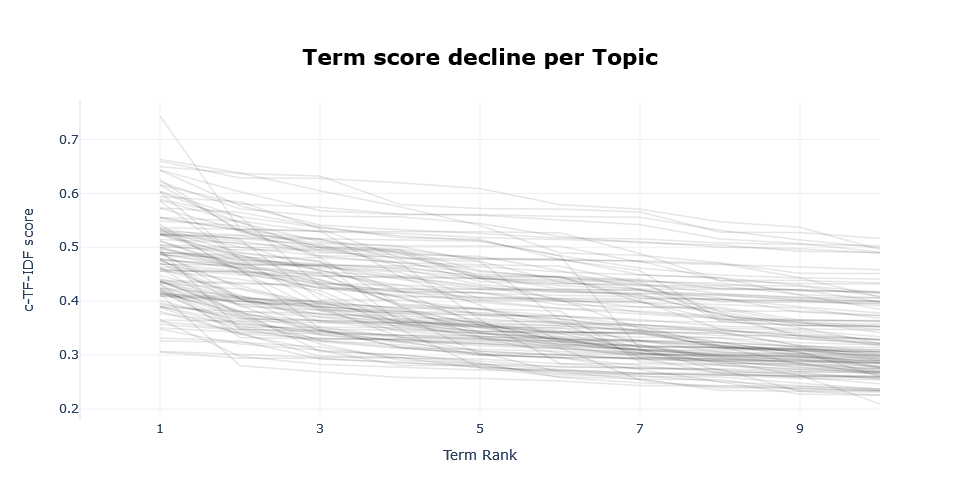

In [116]:
model.visualize_term_rank()

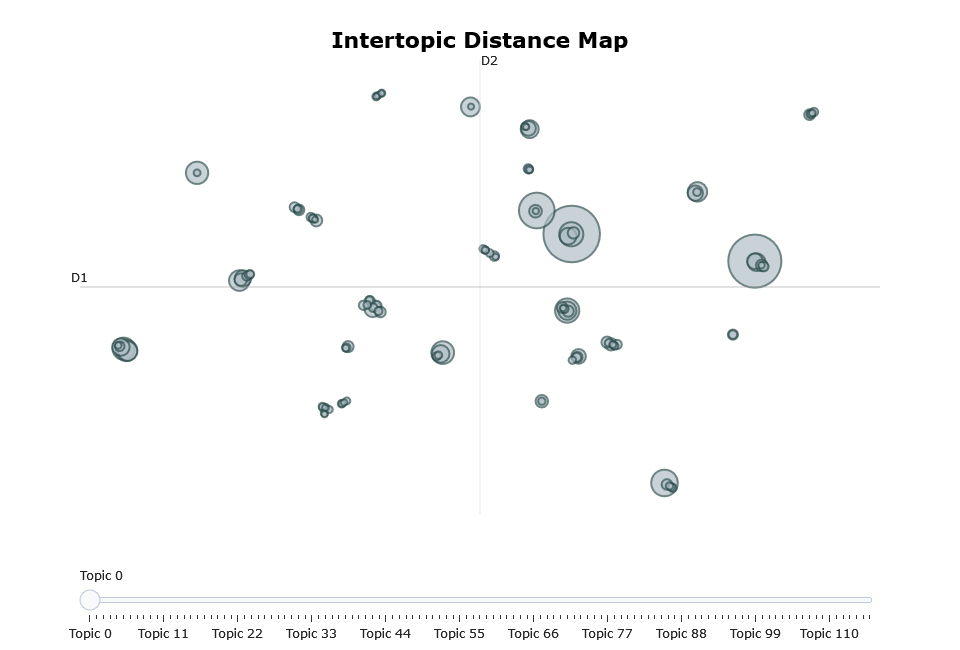

In [86]:
model.visualize_topics()

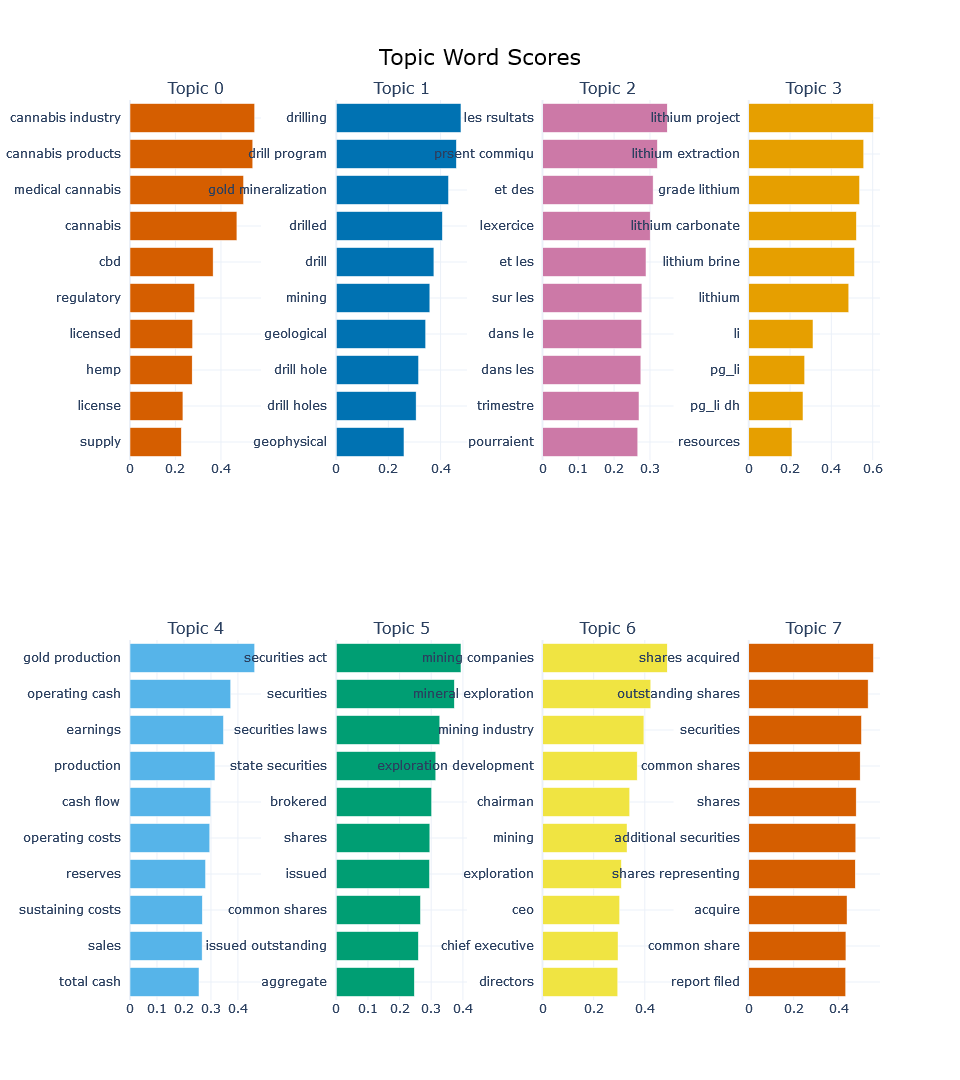

In [87]:
# Bar chart visualization
model.visualize_barchart(n_words=15, width=300, height=540)

In [88]:
raw_data_list[2]

'news release dunsmuir street toll free v7x ssr mining announce quarter vancouver nasdaq ssrm ssrm announces dates consolidated financial results news release conference call investors media public invited listen conference call news release containing consolidated financial results thursday november markets close conference call webcast toll free callers webcast conference call archived replay calling toll free replay code callers replay code canadian based precious metals producer operations including marigold mine operated joint venture also feasibility stage projects portfolio exploration properties committed delivering safe production relentless emphasis also focused growing production mineral reserves exploration acquisition assets accretive growth maintaining financial strength source page'

In [89]:
raw_data1[2]

"News Release 18-15 SSR Mining Inc. PHONE +1 604.689.3846 Suite 800 - 1055 Dunsmuir Street www.ssrmining.com TOLL FREE +1 888.338.0046 PO Box 49088 Vancouver, BC, Canada V7X 1G4 October 15, 2018 SSR MINING TO ANNOUNCE THIRD QUARTER 2018 CONSOLIDATED FINANCIAL RESULTS NOVEMBER 8, 2018 VANCOUVER, B.C.  SSR Mining Inc. (NASDAQ: SSRM) (TSX: SSRM) (SSR Mining) announces the dates for the third quarter 2018 consolidated financial results news release and conference call. Investors, media and the public are invited to listen to the conference call.  News release containing third quarter 2018 consolidated financial results: Thursday, November 8, 2018, after markets close.  Conference call and webcast: Friday, November 9, 2018, at 11:00 a.m. EST. Toll-free in U.S. and Canada: +1 (800) 319-4610 All other callers: +1 (416) 915-3239 Webcast: http://ir.ssrmining.com/investors/events  The conference call will be archived and available on our website. Audio replay will be available for two weeks by c

In [144]:
[raw_data1[2]]

["News Release 18-15 SSR Mining Inc. PHONE +1 604.689.3846 Suite 800 - 1055 Dunsmuir Street www.ssrmining.com TOLL FREE +1 888.338.0046 PO Box 49088 Vancouver, BC, Canada V7X 1G4 October 15, 2018 SSR MINING TO ANNOUNCE THIRD QUARTER 2018 CONSOLIDATED FINANCIAL RESULTS NOVEMBER 8, 2018 VANCOUVER, B.C.  SSR Mining Inc. (NASDAQ: SSRM) (TSX: SSRM) (SSR Mining) announces the dates for the third quarter 2018 consolidated financial results news release and conference call. Investors, media and the public are invited to listen to the conference call.  News release containing third quarter 2018 consolidated financial results: Thursday, November 8, 2018, after markets close.  Conference call and webcast: Friday, November 9, 2018, at 11:00 a.m. EST. Toll-free in U.S. and Canada: +1 (800) 319-4610 All other callers: +1 (416) 915-3239 Webcast: http://ir.ssrmining.com/investors/events  The conference call will be archived and available on our website. Audio replay will be available for two weeks by 

In [147]:
# Transform a single document
document_index = 2  # Index of the document you want to transform
document_topic = model.transform([raw_data_list[document_index]])[0]

print("Topic for Document {}: {}".format(document_index, document_topic))

ValueError: Transform unavailable when model was fit with only a single data sample.

In [ ]:
# Get the topic for a specific document
document_index = 0  # Index of the document you want to get the topic for
document_topic = topics[document_index]

In [90]:

# Check if all values are unique
all_unique = len(set(raw_data_list)) == len(raw_data1)

# Check if any values are duplicate
any_duplicate = len(set(raw_data_list)) != len(raw_data1)

print("All values are unique:", all_unique)
print("Any values are duplicate:", any_duplicate)

All values are unique: False
Any values are duplicate: True


In [91]:
print("==========================================")

In [92]:


model1 = BERTopic(
  embedding_model=sentence_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  calculate_probabilities=True,
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic represenations
)

In [93]:
topics1, probs1 = model1.fit_transform(raw_data1)
dic1 = model1.get_topics()
result_dict1 = {k: {t[0] for t in v} for k, v in dic1.items()}

print(result_dict1.get(2))

{'et', 'lexercice', 'noncs prospectifs', 'prospectifs', 'est', 'prsent communiqu', 'prsent', 'et des', 'dans', 'les rsultats'}


In [118]:
model1.get_topic_info().head()

Topic  Count                                               Name
0     -1   9654                -1_tsx venture_tsx_market_estimates
1      0   2482             0_drilling_drill_mining_mineralization
2      1   1558   1_tsx venture_shares_securities_brokered private
3      2    787     2_les rsultats_et_prospectifs_prsent communiqu
4      3    746  3_lithium carbonate_lithium corp_lithium proje...

In [117]:
model1.generate_topic_labels()[:5]

['-1_tsx venture_tsx_market',
 '0_drilling_drill_mining',
 '1_tsx venture_shares_securities',
 '2_les rsultats_et_prospectifs',
 '3_lithium carbonate_lithium corp_lithium project']

In [96]:
# topic_labels1 = model1.generate_topic_labels(nr_words=4,
#                                             topic_prefix=True,
#                                             #word_length=10,
#                                             separator=" ")

# model1.set_topic_labels(topic_labels1)
# model1.custom_labels_

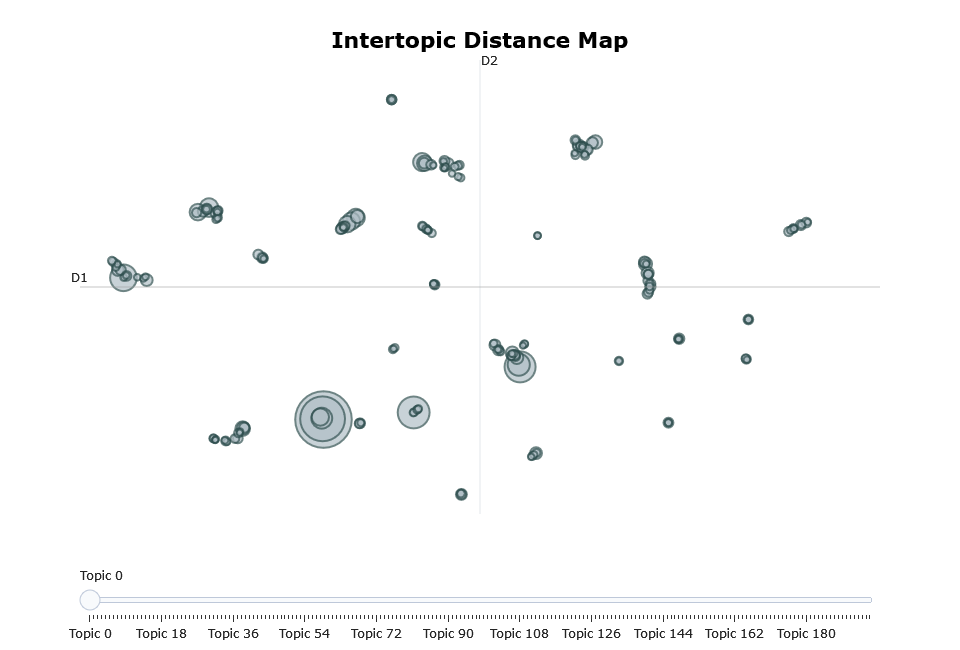

In [97]:
model1.visualize_topics()

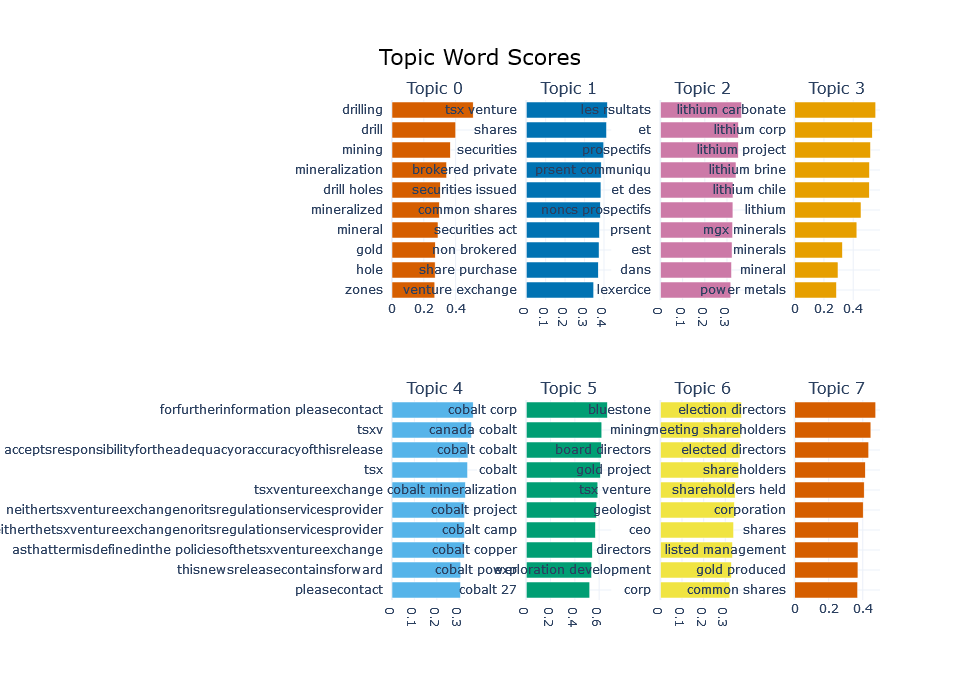

In [122]:
# Bar chart visualization
model1.visualize_barchart(n_words=15, width=400, height=340)

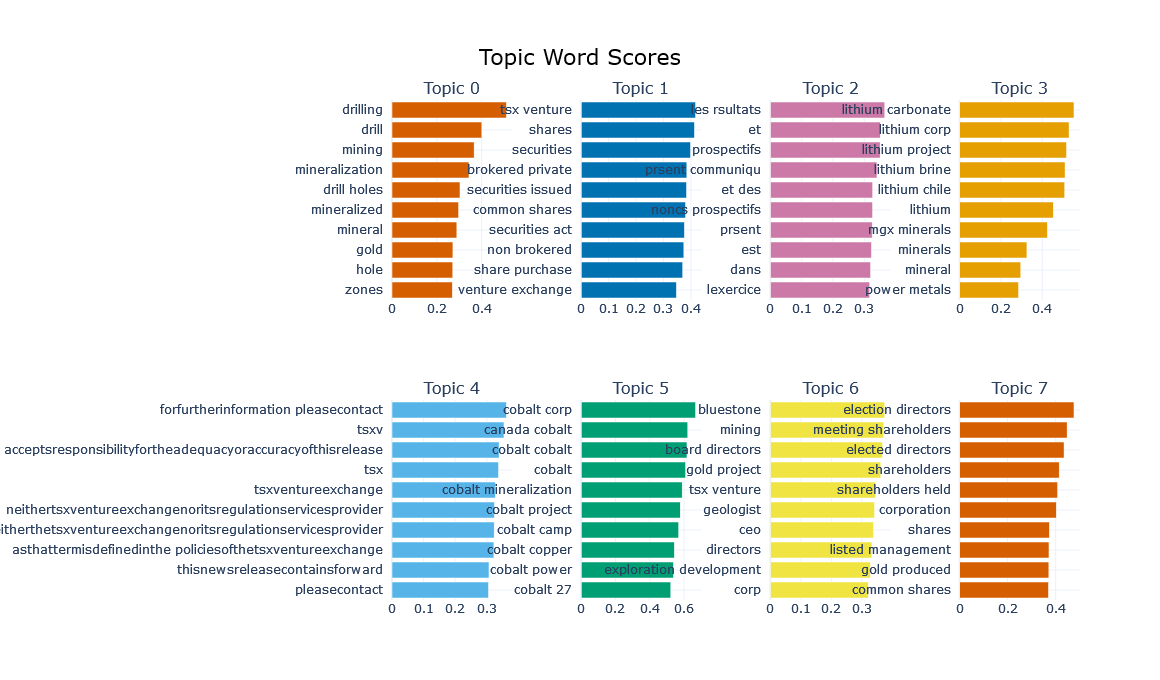

In [123]:
# Bar chart visualization
model1.visualize_barchart(n_words=15, width=300, height=340)

In [68]:
# new_topics1, new_probs1 = model1.reduce_topics(raw_data1, nr_topics=80)

In [129]:
texts = raw_data1[3]
res = model.get_document_info(texts)


In [136]:
#res[res["Topic"]==1]

In [128]:
texts = raw_data1[3]
topics, probs = model1.transform(texts)
#for j, topic in enumerate(topics):
topic_text = model1.get_topic(topics[0])
print(f"Topic for row {topic_text}")

Topic for row [('debentures convertible', 0.646373), ('convertible debentures', 0.64028406), ('debenture offering', 0.6116035), ('debentures', 0.58336514), ('convertible debenture', 0.58299255), ('debentures debentures', 0.5770972), ('principal debentures', 0.53265226), ('securities', 0.45138443), ('debenture', 0.44478327), ('financing', 0.36034578)]


In [137]:

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP

# Prepare embeddings

#sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
#embeddings = sentence_model.encode(raw_data_list, show_progress_bar=False)

# Train BERTopic
#topic_model = embedding_model.fit(raw_data_list, embeddings)

# Reduce dimensionality of embeddings, this step is optional
reduced_embeddings = UMAP( metric='cosine').fit_transform(embeddings)

# Run the visualization with the original embeddings
#model.visualize_documents(raw_data_list, embeddings=embeddings)

In [138]:
# Or, if you have reduced the original embeddings already:
model.visualize_documents(raw_data_list, reduced_embeddings=reduced_embeddings)

IndexError: index 26325 is out of bounds for axis 0 with size 24000

In [ ]:
fig = topic_model.visualize_documents(raw_data_list, reduced_embeddings=reduced_embeddings)
fig.write_html("path/to/file.html") 